 <center> Module EL 3019 
 
 <font color="#0066CC"> **Méthode des K plus proches voisins (Régression)** </font> </center>
<hr>

1. Objectifs  
2. Chargement des bibliothèques et du jeu de données 
3. Prérequis
4. KPPV en régression

<hr>

<font color="#0066CC"> 1. Les objectifs  </font> 
- Ce TP a pour objectif d'apprendre à réaliser le méthode des k plus proches voisins en régression à l'aide de python et des packages appropriés
- En introduction, nous utiliserons cette méthode sur le jeux de données complet puis nous réaliserons un échantillonage dans l'objectif de déterminer le k optimal.

<u>*remarque importante*</u> : les statistiques univariées (disribution, histogrammes) et bivariées (correlations entre les variables, scatter plot) sont intentionnellement omises dans ce TP  (ce n'est pas son objectif). Il n'en demeure pas moins qu'elles doivent être **systématiquement** réalisées lors de l'étude d'un jeux de données 
<br>

<font color="#0066CC">2. Chargement des bibliothèques et du jeu de données </font>    

In [4]:
import numpy as np
import pandas
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

# Importation des données

file = "SURF_data.xlsx"
data = pd.read_excel(file , decimal = ',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   compacité    768 non-null    float64
 1   Surface      768 non-null    float64
 2   mur          768 non-null    float64
 3   toit         768 non-null    float64
 4   hauteur      768 non-null    float64
 5   orientation  768 non-null    int64  
 6   vitrage      768 non-null    float64
 7   or_vitre     768 non-null    int64  
 8   chauff       768 non-null    float64
 9   refroid      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB



<font color="#0066CC"> 3. Pre-requis : les étapes </font>  
Le Jeu de données brut comprend 10 variables. Notre objectif est d'évaluer la méthode des kppv pour l'estimation de la variable *chauff*. La variable *refroid* ne nous interessa pas et sera eliminée. 
Nous avons donc   
* un data.frame X (Predicteur) composé des variables prédictives suivantes :  
  - compacité
  - Surface
  - mur
  - toit
  - hauteur
  - orientation
  - vitrage
  - or_vitre
* un dataframe Y composé uniquement de la variable *chauff*  

<br>

 
3.1. Nous verifions dans un premier temps l'absence / présence de données manquantes   

3.2  Certaines variables, bien que numériques, ne sont pas formatées correctement. En effet, les variables orientation et or_vit se référent à un orientation de type ; nord, sud, est, ouest,.... Il convient donc de les transformer. Deux étapes sont necessaires : (i) la labellisation puis(ii) un One Hot encoding

3.3 La méthode des KPPV est fondée sur la calcul des distances entre les différents individus (lignes du prédicteur). Il est donc important de standardiser les données de type float64






In [5]:
#-> on vérifie la présence / absence de données manquantes
data.isna().sum()
#-> on élimine la variable refroid
data.drop('refroid', axis = 1, inplace=True)
data.head()

,compacité,Surface,mur,toit,hauteur,orientation,vitrage,or_vitre,chauff
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84


Vous devez donc

1. marquer les variables catéorielles (méthode `.astype`)
2. sélectionner les variables catégorielles (méthode `.select_dtypes(include = ...)`)
3. utiliser la librairie `OneHotEncoder` pour transformer les variables
4. recréer un dataframe (la sortie de OHE est un array)
5. sélectionner les variables quantitatives (méthode `.select_dtypes(exclude = ...)`)
6. utiliser la librairie `StandardScaler` pour transformer les variables
7. recréer un dataframe (la sortie de SC est un array)
8. concaténer les deux dataframes

Enfin, créer les matrices X (variables explicatives) et y (réponse)

Les cellules suivantes vous guident dans la démarche standard qui permet d'utiliser les classes de *preprocessing*, en identifiant le stransformations que vous pourriez ensuite utiliser sur de nouveles données. Plus bas, on vous livre une version plus rapide mais moins précautionneuse. 

In [6]:
#___________________________________________________________
#  TRANSFORMATION DES VARIABLES : ONE HOT ENCODING
#___________________________________________________________
# 1. tranformation en variables catégorielle des deux variables
data[['orientation','or_vitre']] = data[['orientation','or_vitre']].astype('category')
# 2. One hot encoding
#---------------------------------------------------
# 2.1. On selectionne les variables catégorielles
df_cat   = data.select_dtypes(include = 'category')
name_cat = df_cat.columns
#---------------------------------------------------
#2.2 Appel et utilisation de la librairie pour l'encodage
OH     = OneHotEncoder(handle_unknown='error',sparse_output=False)
fit_OH = OH.fit(data[name_cat])
fit_data_OH    = fit_OH.transform(data[name_cat])
column_name_OH = fit_OH.get_feature_names_out(name_cat)
#---------------------------------------------------
#2.3 On recrée un dataframe contenant les variables OneHot
dfw_OH = pd.DataFrame(fit_data_OH,columns = column_name_OH)
dfw_OH.reset_index(drop=True, inplace=True)

In [7]:
#___________________________________________________________
#  STANDARDISATION
#___________________________________________________________
# 1. sélection des variables numériques 
dfw_num   = data.select_dtypes(exclude = 'category')

#----------------------------------------------------------
# 2. Centrage et réduction  
SC       =  StandardScaler()
fit_SC   =  SC.fit_transform(dfw_num)
dfw_SC   =  pd.DataFrame(fit_SC, columns = dfw_num.columns)
dfw_SC.reset_index(drop=True, inplace=True)

In [8]:
#____________________________________________________________
# DATAFRAME
#---------------------------------------------------------
# Dataframe contenant les variables standardisées / One Hot encodées
#  On crée différents dataframe
#---------------------------------------------------------
# 1. Dataframe contenant Toutes les variables
dfw_All = pd.concat([dfw_OH, dfw_SC], axis = 1)
dfw_All

#---------------------------------------------------------
# 2. Le dataframe contenant les variables prédictives (Predicteurs)
X_num = dfw_All.drop('chauff', axis = 1)

#---------------------------------------------------------
# 2. Le dataframe contenant la variables à prédire (en régression)
Y_num = dfw_All['chauff']

**Une version rapide alternative..**

In [9]:

var_quanti = ['compacité', 'Surface', 'mur', 'toit', 'hauteur', 'vitrage', 'chauff']
data[var_quanti] = StandardScaler().fit_transform(data[var_quanti])
#
var_quali = ['orientation','or_vitre']
data_quali_encoded = pd.get_dummies(data[var_quali])
# 
df = pd.concat([data[var_quanti], data_quali_encoded], axis = 1)
#
X_num = df.drop('chauff', axis=1)
Y_num = df['chauff']

<font color="#0066CC"> **4. KPPV en régression** </font>     
<font color="#0066CC"> 4.1 Régression avec  k fixe  </font>
* Estimation des valeurs  
Dans le cadre de la régression, l'objectif est de trouver le nombre de plus proche voisins (k) qui permet de "s'approcher" au mieux des valeurs observées dela variable *chauff*.   
Comme nous l'avons vu dans le cours, Deux étapes sont nécessaires :  
  * La phase d'entrainement ou l'on effectue le paramètrage (on fixe le k) sur un échantillon du jeu de données (70%) 
  * Puis la phase de validation (30%) où l'on évalue si le k fixé en entrainement estime correctement les valeurs observées (annotées) sur un autre échantillon du jeux de données (cf. shéma 1)  
  * par défaut, nous fixons le nombre de k plus proches voisins = 20


In [10]:
#_______________________________________________________________________________
# PARTITION DU JEUX DE DONNEES (70% TRAIN - 30% VALIDATION)
X_train, X_test, Y_train, Y_test = train_test_split(X_num, Y_num, test_size= 0.30)

#______________________________________________________________________________
# KNN EN REGRESSION
#-> on récupére le nombre de valeurs en test 
n_test = len(Y_test)
KNN_Reg = KNeighborsRegressor(n_neighbors=20)
KNN_Reg.fit(X_train, Y_train)
Y_pred = KNN_Reg.predict(X_test)
#_____________________________________________________________________________
# On récupère les valeurs prédites
#Y_pred


* Qualité de l'estimation 
 La qualité  de l'estimation correspond à la moyenne de la somme des carrés des écarts entre les valeurs observées et les valeurs prédites (appelée erreur quadratique moyenne ou MSE en anglais) . Plus cette valeur est faible, meilleure sera la qualité de l'ajustement.

In [44]:
MSE = np.sum(np.power(Y_pred - Y_test, 2))
print(type(Y_test))
MSE

<class 'pandas.core.series.Series'>


22.982240705306737

Visualisons la relation à l'aide d'un scatter plot entre les valeurs observée et prédites

In [12]:
import seaborn as sns
sns.set()

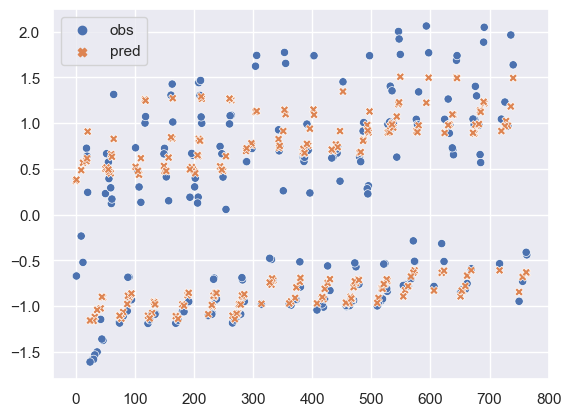

In [40]:
df_result = pd.DataFrame({'obs' : Y_test, 'pred': Y_pred})
_ = sns.scatterplot(df_result)

<font color="#0066CC"> 4.2 Régression avec différentes valeurs de k </font>
* Jusqu'à présent, nous avons fixé le nombre de plus proches voisins (=20) et nous obtenons une valeur de MSE qui reflète une certaine qualité de l'ajustement. La question que l'on peut se poser est alors la suivante :  Peut on améliorer la qualité de l'ajustement en modifiant le nombre de k ?

* Pour y répondre, nous allons incrémenter le nombre de k et calculer, pour chaque incrément de k, l'erreur Quadratique moyenne. 

In [46]:
kmax = 80
#---> On stocke dans un array les erreurs quadratiques moyennes
error_Reg =  np.zeros(kmax)
#--> On fait varier les valeurs de k = 1 à kmax par pas de 1
kppv = np.arange(1,kmax+1,1)
#--> boucle 
for k in kppv:
    KNN_Reg = KNeighborsRegressor(n_neighbors=k)
    KNN_Reg.fit(X_train, Y_train)
    Y_pred = KNN_Reg.predict(X_test)
    #--> calcul MSE
    MSE = np.sum(np.power(Y_pred - Y_test, 2))
    #--> et stockage dans la liste
    error_Reg[k-1] = MSE


* Nous construisons le graphique MSE = f(k) et nous calculons le k optimal


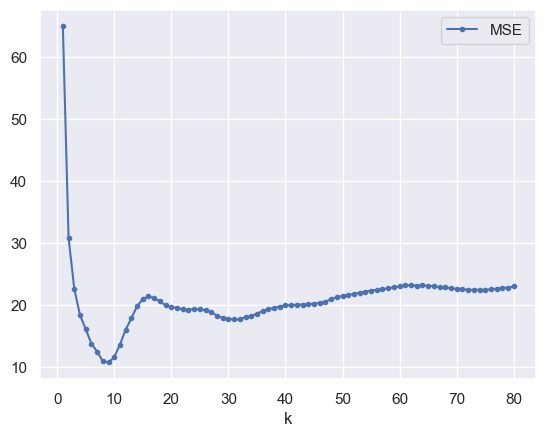

In [47]:
df_result_Reg = pd.DataFrame({ 
                          'k'   : kppv,
                          'MSE' : error_Reg
                        })

k_opt = df_result_Reg['MSE'].values.argmin(0) + 1

_ = df_result_Reg.plot(x='k', y='MSE', style='.-')


* Nous comparons les valeurs observées (en x)  par rapport aux valeurs prédites pour k = 15 et pour le k optimal (en y). En théorie, si les prédictions correspondent "exactement" aux observations, on observe une droite. Comme ce n'est jamais le cas, plus les points se 'rapprocheront' d'une droite meilleure sera la prédiction

,obs,pred,pred_opt
42,-1.144151,-1.024154,-1.363648
527,-0.837714,-0.723345,-0.747799
263,1.087188,1.252543,1.047630
64,1.314289,0.828501,0.991764
478,-0.763336,-0.705829,-0.591660


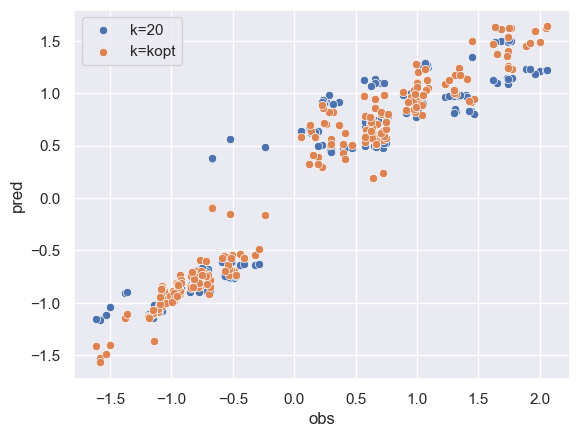

In [43]:

#-> On calcule les valeurs pour le k optimal
KNN_Reg = KNeighborsRegressor(n_neighbors=9)
KNN_Reg.fit(X_train, Y_train)
Y_pred_opt = KNN_Reg.predict(X_test)

#--> On ajoute au dataFrame la variable pred_opt = résultats obtenus avec le k optimal
df_result['pred_opt'] = Y_pred_opt

_ = sns.scatterplot(x='obs', y='pred', data=df_result, label='k=20')
_ = sns.scatterplot(x='obs', y='pred_opt', data=df_result, label='k=kopt')
df_result.head()

In [18]:
df_result.head()

,obs,pred,pred_opt
42,-1.144151,-1.203256,-1.363648
527,-0.837714,-0.669718,-0.747799
263,1.087188,1.145600,1.047630
64,1.314289,1.017372,0.991764
478,-0.763336,-0.652810,-0.591660


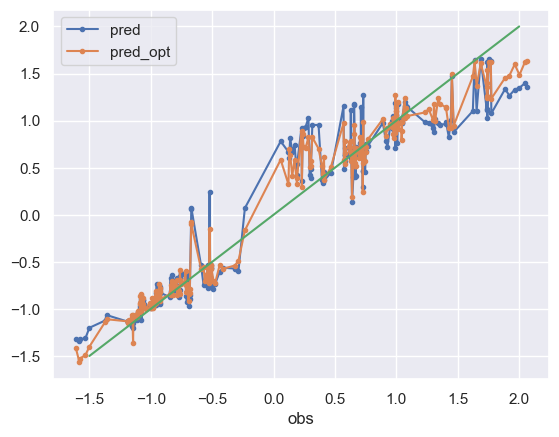

In [19]:
ax = df_result.sort_values(by='obs').plot(x='obs', y='pred', style='.-')
df_result.sort_values(by='obs').plot(x='obs', y='pred_opt', style='.-', ax=ax)
_ = ax.plot([-1.5, 2],[-1.5, 2], label='optimal')

* Comme on peut l'observer, il y a moins de dispersion des points lorsque nous utilisons le k_optimal (en marron sur le graphique)


## Test Ploty:
Animated graph for $k \in [0;80]$

In [20]:
def make_df(d : dict, k : int, MSE : int, pred, test):

    d.update({"k_{}".format(k): [MSE, pd.DataFrame([df_result['obs'],test, pred], index=['obs', 'test', 'pred'])]})

    df = pd.DataFrame(data=d, index=["MSE", "scartter"])

    return df

In [21]:
def knn(kmax : int = 80) -> pd.DataFrame:

    error_Reg =  np.zeros(kmax)
    kppv = np.arange(1,kmax+1,1)

    d = {}
    for k in kppv:
        KNN_Reg = KNeighborsRegressor(n_neighbors=k)
        KNN_Reg.fit(X_train, Y_train)
        Y_pred = KNN_Reg.predict(X_test)

        MSE = np.sum(np.power(Y_pred - Y_test, 2))
        error_Reg[k-1] = MSE

        out = make_df(d, k, MSE,Y_test , Y_pred)

    return out

In [22]:
df_res_ploty = knn(5)

In [23]:
df_res_ploty

,k_1,k_2,k_3,k_4,k_5
MSE,64.953462,30.825921,22.621096,18.349135,16.099272
scar,42 527 263 64 ...,42 527 263 64 ...,42 527 263 64 ...,42 527 263 64 ...,42 527 263 64 ...


In [24]:
df_res_ploty['k_1'][1]

,42,527,263,64,478,351,546,90,277,234,...,426,433,669,306,391,55,74,430,191,206
obs,-1.144151,-0.837714,1.087188,1.314289,-0.763336,0.261097,2.002533,-0.683007,-1.087623,-0.692924,...,-0.560036,0.619103,-0.590779,1.740722,0.990001,0.573484,-1.184811,-0.828788,-0.949776,0.127217
test,1.421393,NaN,NaN,-0.704825,NaN,NaN,NaN,0.225395,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.048872,-0.694908,NaN,-0.973577,-0.627472
pred,-1.144151,-0.837714,1.087188,1.314289,-0.763336,0.261097,2.002533,-0.683007,-1.087623,-0.692924,...,-0.560036,0.619103,-0.590779,1.740722,0.990001,0.573484,-1.184811,-0.828788,-0.949776,0.127217


In [25]:
df_res_ploty.iat(1)

TypeError: '_iAtIndexer' object is not callable

In [38]:
import plotly.express as px
'''
On regarder le placement des points pour '''
px.scatter(df_result, template="plotly_dark",
           # x='observation', y='prediction',
            range_x=[-10,800], range_y=[-2.5,2.5])

In [30]:
import plotly.express as px
df = px.data.gapminder()
px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country", template="plotly_dark",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])